Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

In [2]:
with open('logins.json') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [6]:
df['login_time'] = pd.to_datetime(df['login_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Any missing values ?

In [8]:
df[(df.login_time.dt.hour == 0) & (df.login_time.dt.minute == 0) & (df.login_time.dt.second == 0)].login_time

32456   1970-02-15
37739   1970-02-21
Name: login_time, dtype: datetime64[ns]

In [10]:
df = df[~((df.login_time.dt.hour == 0) & (df.login_time.dt.minute == 0) & (df.login_time.dt.second == 0))]

Dates values ok?

In [11]:
df[(df.login_time.dt.day == 0) | (df.login_time.dt.month == 0) | (df.login_time.dt.year == 0)].login_time

Series([], Name: login_time, dtype: datetime64[ns])

In [12]:
df_sort = df.sort_values(by='login_time')

In [14]:
# count logins based on 15 minutes interval 

df_15m = pd.DataFrame(df_sort.resample('15T', on='login_time').size(), columns=['count'])



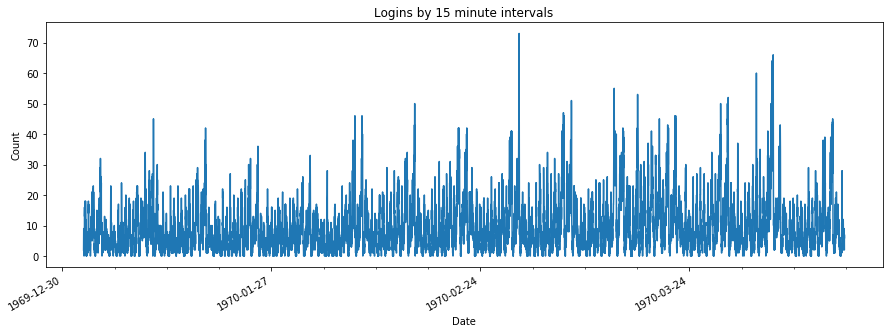

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(15, 5))
plt.title('Logins by 15 minute intervals')
plt.ylabel('Count')
plt.xlabel('Date')
ax.plot(df_15m['count'])
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.show()

Average logins per day

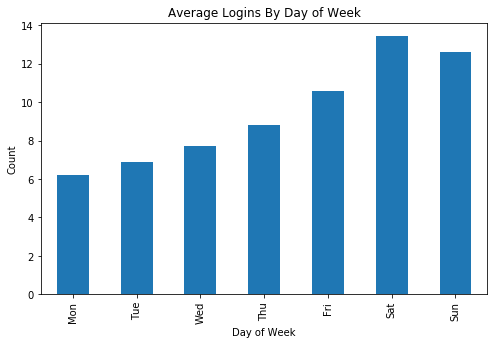

In [16]:
import calendar
fig, ax = plt.subplots(figsize=(8, 5))
df_15m['weekday'] = df_15m.index.weekday
dgroups = df_15m[['count', 'weekday']].groupby('weekday').mean().plot(kind='bar', ax=ax, legend=None)
plt.title('Average Logins By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
labels = (list(calendar.day_abbr))
ax.set_xticklabels(labels)

plt.show()


Part 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

    What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

    Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the observation
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.




Response:

    As the goal of the operations managers is to encourage driver partners to be available in both cities, I would choose the proportion of rides that result in a toll charge compared to the total number of rides. Measuring a change in this statistic will indicate whether or not driver partners are actually crossing the toll bridge more often to pick up riders.

    That said, I would also measure average profit per ride as it will not help the company if the cost of reimbursing toll fees results in a lower profit.

    a. Randomly select a portion of the drivers in each city, about 10-20% of the toal drivers. Divide the drivers randomly into two groups.
    Group A will be the control and not be reimbursed toll fees.
    Group B will be the test group and will be reimbursed toll fees.

    Run the test for a number of weeks. We need to make the test period even multiples of weeks to avoid bias from the different activity patterns on weekdays and weekends. We need the test period to run long enough to get a big enough sample to be confident our result is representative of long term operations. We should avoid testing during extended holiday seasons. Depending on the volume of rides, perhaps 2-4 weeks would be appropriate.

    b. Use a two-sided t-test on the proportions to determine whether or not there is a statistically significant change.
    The null hypothesis would be that there is no change in the proportion of rides resulting in a toll charge.
    The alternate hypothesis is that the test group has a different proportion than the control group.

    I use the two-sided t-test to avoid an increase in type I error in a one-sided test that only looks for the proportion being greater in the test group. Also, we need to know whether the proportion is less in the test group even though we don't expect that to happen.

    I would suggest a significance level of .05, which would correspond to .025 on each end of the test. I would report the 95% confidence interval of the difference in proportion so we know whether the test group has a higher or lower proportion than the control if they are not equal.

    c. I would report the results of the t-test, showing whether we had enough evidence to reject the null hypothesis.
    I would report the confidence interval of the difference of proportions and explain to them we have a 95% probability of the actual difference falling between these values.

    I would use the same process to analyze the difference in mean profit per ride to see if there was a statistically significant change with the toll reimbursements.

    I would explain that with a significance level of .05, the values we measure have a 5% chance of happening due to random chance and having nothing to do with the toll reimbursement.




Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

    Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

    Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

    Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Data description:
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYY MM DD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday


In [17]:
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [18]:
with open('ultimate_data_challenge.json') as ult_file:
    ult_data = json.load(ult_file)
ult_df = pd.DataFrame(ult_data)   
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
ult_df.last_trip_date = pd.to_datetime(ult_df.last_trip_date)
ult_df.signup_date = pd.to_datetime(ult_df.signup_date)

In [20]:
ult_df[ult_df.avg_dist > 50].sort_values('avg_dist', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
1302,Winterfell,1,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
22290,Astapor,0,2014-01-12,5.0,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.0
47595,King's Landing,0,2014-01-25,5.0,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.0
36625,Astapor,2,2014-01-19,5.0,1.0,2014-01-22,iPhone,0.0,False,100.0,73.88,3.0
22096,Astapor,0,2014-01-17,NaN,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.0
1493,Astapor,1,2014-01-26,5.0,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.0
19197,Astapor,2,2014-01-17,4.7,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.0
42835,Winterfell,0,2014-01-10,5.0,1.0,2014-06-28,Android,0.0,False,100.0,70.48,5.0


In [21]:
ult_df[ult_df.trips_in_first_30_days > 45][['avg_dist', 'trips_in_first_30_days']].sort_values('trips_in_first_30_days', 
                                                                                        ascending=False)

,avg_dist,trips_in_first_30_days
18514,2.02,125
99,2.86,73
3030,2.32,71
29070,1.45,63
48804,2.30,58
45489,3.65,56
36917,3.51,56
29043,3.39,55
17942,3.27,55
33488,2.91,54


In [22]:
ult_df[ult_df.avg_surge > 4.0][['surge_pct', 'avg_surge', 'city']].sort_values('avg_surge', ascending=False)

,surge_pct,avg_surge,city
13861,100.0,8.00,Winterfell
30477,100.0,5.75,Winterfell
21894,100.0,5.00,Winterfell
19191,100.0,5.00,Winterfell
47052,100.0,5.00,Winterfell
2817,100.0,5.00,Winterfell
49383,100.0,5.00,Winterfell
1405,100.0,4.75,Winterfell
21742,100.0,4.50,Winterfell
15334,100.0,4.50,Winterfell



Before modeling, we need to address the missing/bad data and create target.

    Null ratings: impute to fill nulls.
    Null phone types: impute to fill nulls.
    Bad 0 values in avg_dist, trips_in_first_30_days: change to null then impute to fill nulls.
    Outliers in avg_surge, trips_in_first_30_days: drop as they are only two users and could significantly affect our model.
    Target is boolean last_trip_date is in last 30 days of data.



In [23]:
# Leave out the two outliers. 
clean_df = ult_df[(ult_df.avg_surge < 8)]
clean_df = clean_df[clean_df.trips_in_first_30_days < 125]

In [24]:
phone_int = {"Android": 1, "iPhone": 2, None: None}
city_int = {"Astapor": 1, "King\'s Landing": 2, "Winterfell":3}

In [25]:
clean_df['phone_int'] = clean_df.apply(lambda row: phone_int[row['phone']], axis=1)

In [26]:
clean_df['city_int'] = clean_df.apply(lambda row: city_int[row['city']], axis=1)

In [27]:
jan_1 = datetime.strptime('Jan 1 2014', '%b %d %Y')
clean_df['signup_days_since_jan_1'] = clean_df.apply(lambda row: (row['signup_date'] - jan_1).days, axis=1)
clean_df['last_trip_days_since_jan_1'] = clean_df.apply(lambda row: (row['last_trip_date'] - jan_1).days, axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   city                        49998 non-null  object        
 1   trips_in_first_30_days      49998 non-null  int64         
 2   signup_date                 49998 non-null  datetime64[ns]
 3   avg_rating_of_driver        41876 non-null  float64       
 4   avg_surge                   49998 non-null  float64       
 5   last_trip_date              49998 non-null  datetime64[ns]
 6   phone                       49602 non-null  object        
 7   surge_pct                   49998 non-null  float64       
 8   ultimate_black_user         49998 non-null  bool          
 9   weekday_pct                 49998 non-null  float64       
 10  avg_dist                    49998 non-null  float64       
 11  avg_rating_by_driver        49797 non-null  float64   

In [28]:
last_date = ult_df['last_trip_date'].max()
clean_df['active'] = clean_df.apply(lambda row: (last_date - row['last_trip_date']).days <= 30, axis=1)


In [29]:
clean_imp = clean_df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'city_int', 
                      'last_trip_days_since_jan_1', 'phone_int', 'signup_days_since_jan_1', 'surge_pct', 
                      'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'active']]

In [30]:
y = clean_imp['active']
X = clean_imp.drop(columns=['active'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [31]:
imp = IterativeImputer(random_state=0)
X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_test_filled = pd.DataFrame(imp.transform(X_test))

In [32]:
X_train_filled.columns = X.columns
X_train_filled.index = X_train.index
X_train_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000
mean,5.787106,4.777100,4.604803,1.074364,2.137122,108.300846,1.696703,15.552574,8.855166,2.269730,0.376422,60.847486
std,5.645964,0.448245,0.564806,0.217495,0.882712,61.682522,0.457902,8.744020,20.000245,3.709413,0.484495,37.124033
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.430000,4.700000,4.500000,1.000000,1.000000,44.000000,1.000000,8.000000,0.000000,0.000000,0.000000,33.300000
50%,3.890000,5.000000,4.800000,1.000000,2.000000,127.000000,2.000000,16.000000,0.000000,1.000000,0.000000,66.700000
75%,6.930000,5.000000,5.000000,1.050000,3.000000,168.000000,2.000000,23.000000,8.500000,3.000000,1.000000,100.000000
max,129.890000,5.050771,5.000000,5.000000,3.000000,181.000000,2.000000,30.000000,100.000000,73.000000,1.000000,100.000000


In [33]:
X_train_filled.loc[X_train_filled['avg_rating_by_driver'] > 5.0, 'avg_rating_by_driver'] = 5.0
X_train_filled.loc[X_train_filled['avg_rating_of_driver'] > 5.0, 'avg_rating_of_driver'] = 5.0
X_train_filled = X_train_filled.round({'phone_int': 0})
X_train_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000,34998.000000
mean,5.787106,4.777099,4.604803,1.074364,2.137122,108.300846,1.699211,15.552574,8.855166,2.269730,0.376422,60.847486
std,5.645964,0.448244,0.564806,0.217495,0.882712,61.682522,0.458607,8.744020,20.000245,3.709413,0.484495,37.124033
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.430000,4.700000,4.500000,1.000000,1.000000,44.000000,1.000000,8.000000,0.000000,0.000000,0.000000,33.300000
50%,3.890000,5.000000,4.800000,1.000000,2.000000,127.000000,2.000000,16.000000,0.000000,1.000000,0.000000,66.700000
75%,6.930000,5.000000,5.000000,1.050000,3.000000,168.000000,2.000000,23.000000,8.500000,3.000000,1.000000,100.000000
max,129.890000,5.000000,5.000000,5.000000,3.000000,181.000000,2.000000,30.000000,100.000000,73.000000,1.000000,100.000000


In [34]:
X_test_filled.index = X_test.index
X_test_filled.columns = X.columns
X_test_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,5.819760,4.780635,4.600017,1.075233,2.133467,108.416400,1.69779,15.528267,8.829953,2.289867,0.378600,61.106127
std,5.848509,0.440124,0.572046,0.226304,0.882254,61.800967,0.45740,8.777103,19.849790,3.852328,0.485054,36.983677
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.400000,4.700000,4.500000,1.000000,1.000000,44.000000,1.00000,8.000000,0.000000,0.000000,0.000000,33.300000
50%,3.860000,5.000000,4.749957,1.000000,2.000000,127.000000,2.00000,16.000000,0.000000,1.000000,0.000000,66.700000
75%,6.970000,5.000000,5.000000,1.050000,3.000000,168.000000,2.00000,23.000000,8.700000,3.000000,1.000000,100.000000
max,160.960000,5.805887,5.238452,5.750000,3.000000,181.000000,2.00000,30.000000,100.000000,71.000000,1.000000,100.000000


In [35]:
X_test_filled.loc[X_test_filled['avg_rating_by_driver'] > 5.0, 'avg_rating_by_driver'] = 5.0
X_test_filled.loc[X_test_filled['avg_rating_of_driver'] > 5.0, 'avg_rating_of_driver'] = 5.0
X_test_filled = X_test_filled.round({'phone_int':0})
X_test_filled.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city_int,last_trip_days_since_jan_1,phone_int,signup_days_since_jan_1,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,5.819760,4.780581,4.600001,1.075233,2.133467,108.416400,1.700333,15.528267,8.829953,2.289867,0.378600,61.106127
std,5.848509,0.440048,0.572032,0.226304,0.882254,61.800967,0.458127,8.777103,19.849790,3.852328,0.485054,36.983677
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.400000,4.700000,4.500000,1.000000,1.000000,44.000000,1.000000,8.000000,0.000000,0.000000,0.000000,33.300000
50%,3.860000,5.000000,4.749957,1.000000,2.000000,127.000000,2.000000,16.000000,0.000000,1.000000,0.000000,66.700000
75%,6.970000,5.000000,5.000000,1.050000,3.000000,168.000000,2.000000,23.000000,8.700000,3.000000,1.000000,100.000000
max,160.960000,5.000000,5.000000,5.750000,3.000000,181.000000,2.000000,30.000000,100.000000,71.000000,1.000000,100.000000


In [36]:
X_train_dummy = pd.get_dummies(X_train_filled, columns=['city_int', 'phone_int', 'ultimate_black_user'], drop_first=True)
X_train_dummy.index = X_train.index
X_test_dummy = pd.get_dummies(X_test_filled, columns=['city_int', 'phone_int', 'ultimate_black_user'], drop_first=True)
X_test_dummy.index = X_test.index


**Scale**


In [37]:


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cont_cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'last_trip_days_since_jan_1', 
             'signup_days_since_jan_1', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_filled[cont_cols]))
scaled_X_test_cont = pd.DataFrame(scaler.transform(X_test_filled[cont_cols]))
scaled_X_train_cont.columns = cont_cols
scaled_X_train_cont.index = X_train.index
scaled_X_test_cont.columns = cont_cols
scaled_X_test_cont.index = X_test.index



**Concatenate**

In [38]:
X_train_dummy = X_train_dummy[['city_int_2.0', 'city_int_3.0', 'phone_int_2.0', 'ultimate_black_user_1.0']]
X_test_dummy = X_test_dummy[['city_int_2.0', 'city_int_3.0', 'phone_int_2.0', 'ultimate_black_user_1.0']]
X_train_processed = pd.concat([scaled_X_train_cont, X_train_dummy],axis='columns')
X_test_processed = pd.concat([scaled_X_test_cont, X_test_dummy],axis='columns')

In [ ]:
X_train_processed = X_train_processed.drop(columns=['last_trip_days_since_jan_1', 'avg_surge']).to_numpy()

In [ ]:
X_test_processed = X_test_processed.drop(columns=['last_trip_days_since_jan_1', 'avg_surge']).to_numpy()

**Build the Model**

In [43]:
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced').fit(X_train_processed, y_train)

In [44]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(class_weight='balanced')

# define parameter values
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.001]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_processed, y_train)

# summarize results
print(f"Best score on training data: {grid_result.best_score_} using {grid_result.best_params_}")
model = grid_search.best_estimator_
y_pred = model.predict(X_test_processed)
print('Best score on test data: {}'.format(accuracy_score(y_pred, y_test)))

/Users/orangesun/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best score on training data: 1.0 using {'C': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Best score on test data: 1.0


In [41]:
from sklearn.metrics import classification_report
target_names = ['Not Active', 'Active']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Active       1.00      1.00      1.00      9359
      Active       1.00      1.00      1.00      5641

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



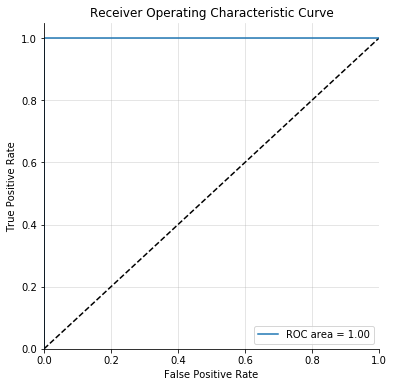

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_df(clf, X_test, y_test, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for binary model supporting .decision_function().
    
    Input: 
        clf: Trained  binary Classifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        figsize: Figure size of plot, optional
    """
    y_score = clf.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1.0)
    roc_auc = auc(fpr, tpr)

    # plot roc 
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    ax.plot(fpr, tpr, label='ROC area = %0.2f' % (roc_auc))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_roc_df(model, X_test_processed, y_test, figsize=(6, 6))